In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bmh")
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import TensorBoard
from keras.metrics import RootMeanSquaredError
from pathlib import Path
from time import strftime
import shap
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("../../DATA/Data_increase.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
df["LLD-LLS"] = df.log_LLD - df.log_LLS
df["GR-GKUT"] = df.GR - df.GKUT
df.head()

,DEPT,GR,GKUT,NPHI,PE,RHOB,DRHO,well,log_LLS,log_LLD,LLD-LLS,GR-GKUT
0,2705.2524,19.0270,18.7281,0.0513,5.2064,2.6527,0.0198,1,0.699109,0.749381,0.050272,0.2989
1,2705.4048,15.8497,16.5070,0.0468,5.2632,2.6564,0.0229,1,0.708140,0.769960,0.061820,-0.6573
2,2705.5572,13.3455,14.3921,0.0411,5.2742,2.6546,0.0218,1,0.751779,0.823416,0.071636,-1.0466
3,2705.7096,12.2315,13.6969,0.0369,5.2543,2.6488,0.0202,1,0.787269,0.865447,0.078178,-1.4654
4,2705.8620,13.0494,13.2589,0.0322,5.1625,2.6475,0.0145,1,0.833886,0.921738,0.087852,-0.2095


In [3]:
train = df[~df['well'].isin(df.groupby("well").get_group(6)['well'])]
train = train[~train['well'].isin(train.groupby("well").get_group(4)['well'])]
test = df.groupby("well").get_group(6)
val = df.groupby("well").get_group(4)

X_train = train.drop(["NPHI", "RHOB","DRHO", "well"], axis=1)
y_train = train["NPHI"]

X_test = test.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)
y_test = test["NPHI"]

X_val = val.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)
y_val = val["NPHI"]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [4]:
def get_run_logdir(root_logdir="./logs/my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")
run_logdir = get_run_logdir()

# def model_creator():
#     input_layer = keras.layers.Input(shape=(8))
    
#     layer1 = keras.layers.Dense(69, "linear", name="layer1")(input_layer)
#     drop1 = keras.layers.Dropout(0.3)(layer1)
    
#     layer2 = keras.layers.Dense(92, "softsign", name="layer2")(drop1)
    
#     layer3 = keras.layers.Dense(186, "tanh", name="layer3")(layer2)
#     drop3 = keras.layers.Dropout(0.3)(layer3)
#     Norm3 = keras.layers.BatchNormalization()(drop3)
    
#     layer4 = keras.layers.Dense(142, "linear", name="layer4")(Norm3)

    
#     output_layer = keras.layers.Dense(1, "linear", name="output_layer")(layer4)
    
#     model = keras.Model(inputs=input_layer, outputs=output_layer)
#     optimizer =keras.optimizers.Adamax(learning_rate=2.62177701e-03)
#     model.compile(loss="mse", optimizer=optimizer, metrics=[RootMeanSquaredError()])
#     return model

def model_creator():
    input_layer = keras.layers.Input(shape=(8))
    
    layer1 = keras.layers.Dense(77, "selu", name="layer1")(input_layer)
    
    
    layer2 = keras.layers.Dense(183, "softsign", name="layer2")(layer1)
    drop1 = keras.layers.Dropout(0.3)(layer2)
    Norm1 = keras.layers.BatchNormalization()(drop1)
    
    layer3 = keras.layers.Dense(31, "sigmoid", name="layer3")(layer2)
    drop4 = keras.layers.Dropout(0.3)(layer3)
    Norm4 = keras.layers.BatchNormalization()(drop4)
    
    layer4 = keras.layers.Dense(143, "tanh", name="layer4")(Norm4)
    

    
    output_layer = keras.layers.Dense(1, "linear", name="output_layer")(layer4)
    
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    optimizer =keras.optimizers.Adamax(learning_rate=1.3462815e-03)
    model.compile(loss="mse", optimizer=optimizer, metrics=[RootMeanSquaredError()])
    return model

Epoch 1/1000
298/298 [==============================] - 3s 6ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 2/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 3/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.0053 - root_mean_squared_error: 0.0728 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 4/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.0041 - root_mean_squared_error: 0.0641 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 5/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.0033 - root_mean_squared_error: 0.0578 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 6/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.0029 - root_mean_squared_error: 0.0543 - val_loss: 0

Epoch 48/1000
298/298 [==============================] - 1s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377


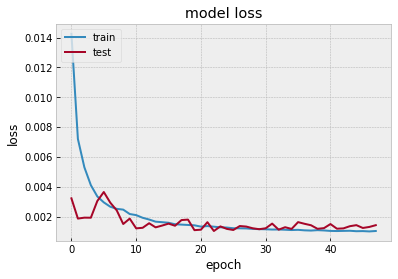

43/43 [==============================] - 0s 2ms/step
0.7383229700834987


In [16]:
model = model_creator()
    
    
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,profile_batch=(100, 200))
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f"model_best2.h5", save_weights_only=True,best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True)

history = model.fit(X_train, y_train,
                batch_size=50,
                callbacks=[early_stopping_cb,checkpoint_cb,tensorboard_cb],
                validation_data=(X_val, y_val),
                epochs=1000,
                verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(r2_score(y_test, model.predict(X_test)))

In [5]:
from keras.models import load_model
model = model_creator()

model.load_weights("model_best2.h5")

In [6]:
print("best_model:R2")
print(r2_score(y_train, model.predict(X_train)))
print(mean_absolute_error(y_train, model.predict(X_train)))
print(mean_squared_error(y_train, model.predict(X_train)))

best_model:R2
466/466 [==============================] - 1s 1ms/step
0.7802799587519598
466/466 [==============================] - 1s 1ms/step
0.02411461855890544
466/466 [==============================] - 1s 1ms/step
0.0010602917099968533


In [7]:
print("best_model:R2")
print(r2_score(y_test, model.predict(X_test)))
print(mean_absolute_error(y_test, model.predict(X_test)))
print(mean_squared_error(y_test, model.predict(X_test)))

best_model:R2
43/43 [==============================] - 0s 1ms/step
0.7383229700834987
43/43 [==============================] - 0s 1ms/step
0.024788388598281492
43/43 [==============================] - 0s 1ms/step
0.001043587458853499


In [8]:
print("best_model:R2")
print(r2_score(y_val, model.predict(X_val)))
print(mean_absolute_error(y_val, model.predict(X_val)))
print(mean_squared_error(y_val, model.predict(X_val)))

best_model:R2
38/38 [==============================] - 0s 1ms/step
0.6991264479129184
38/38 [==============================] - 0s 1ms/step
0.024611826718451805
38/38 [==============================] - 0s 1ms/step
0.001028721103453324


In [10]:
# Initialize the SHAP explainer
explainer = shap.Explainer(model1, X_train)

# Compute the SHAP values
shap_values = explainer(X_train)

ExactExplainer explainer: 11105it [12:24, 14.92it/s]                                                                   


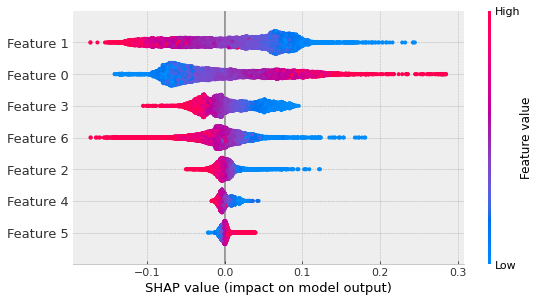

In [11]:
# Plot the SHAP values
shap.summary_plot(shap_values, X_train)

43/43 [==============================] - 0s 1ms/step


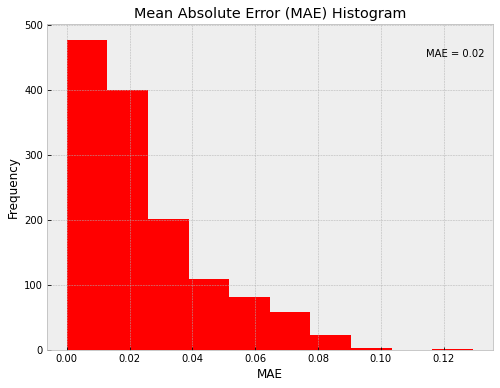

In [9]:
# Calculate the Mean Absolute Error (MAE)
y_pred = model.predict(X_test)
mae = np.abs(y_test - np.reshape(y_pred,(np.shape(y_pred)[0],)))
MAE = np.sum(mae)/(len(y_pred))
# Plot the MAE histogram
plt.figure(figsize=(8, 6))
plt.hist(mae, color="r")
# , bins=3, edgecolor='red'
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.title('Mean Absolute Error (MAE) Histogram')
plt.text(0.85, 0.9, f"MAE = {MAE:.2f}", transform=plt.gca().transAxes)
plt.savefig("MAE.png")
plt.show()

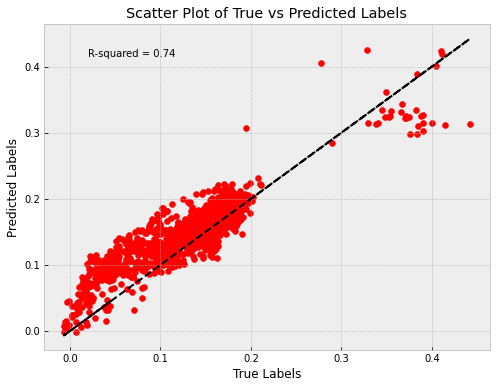

In [10]:
# y_pred = np.reshape(y_pred,(1357,))
# Plot the scatter plot
r2 = r2_score(y_test, y_pred)
plt.figure(figsize=(8, 6))

plt.plot(y_test,y_test, linestyle = 'dashed', color="black")
plt.scatter(y_test, y_pred, color="r")
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Scatter Plot of True vs Predicted Labels')
plt.text(0.1, 0.9, f"R-squared = {r2:.2f}", transform=plt.gca().transAxes)
plt.savefig("sctatter.png")
plt.show()

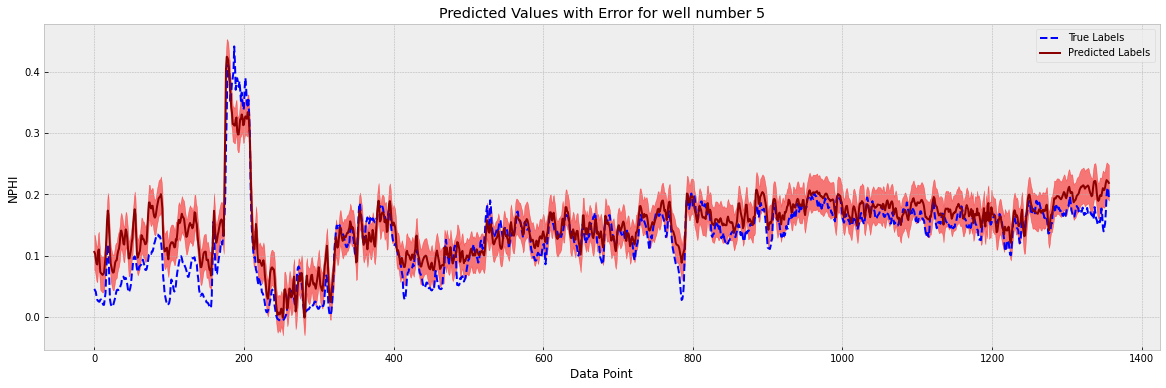

In [11]:
y_pred = np.reshape(y_pred, (1357,))
y_true = y_test.values
# Calculate the error between true and predicted labels
error = y_true - y_pred

# Plot the predicted values and error
plt.figure(figsize=(20, 6))
plt.plot(y_true, label='True Labels', color="b", alpha=1, linestyle = 'dashed')
plt.plot(y_pred, label='Predicted Labels', color="darkred")
plt.fill_between(range(len(y_true)), y_pred-0.029, y_pred+0.029, alpha=0.5, color='red')

plt.xlabel('Data Point')
plt.ylabel('NPHI')
plt.title('Predicted Values with Error for well number 5')
plt.legend()
plt.savefig("plot.png")
plt.show()

In [12]:
train.head()

,DEPT,GR,GKUT,NPHI,PE,RHOB,DRHO,well,log_LLS,log_LLD,LLD-LLS,GR-GKUT
0,2705.2524,19.0270,18.7281,0.0513,5.2064,2.6527,0.0198,1,0.699109,0.749381,0.050272,0.2989
1,2705.4048,15.8497,16.5070,0.0468,5.2632,2.6564,0.0229,1,0.708140,0.769960,0.061820,-0.6573
2,2705.5572,13.3455,14.3921,0.0411,5.2742,2.6546,0.0218,1,0.751779,0.823416,0.071636,-1.0466
3,2705.7096,12.2315,13.6969,0.0369,5.2543,2.6488,0.0202,1,0.787269,0.865447,0.078178,-1.4654
4,2705.8620,13.0494,13.2589,0.0322,5.1625,2.6475,0.0145,1,0.833886,0.921738,0.087852,-0.2095


ExactExplainer explainer: 1358it [01:04, 19.12it/s]                                                                    


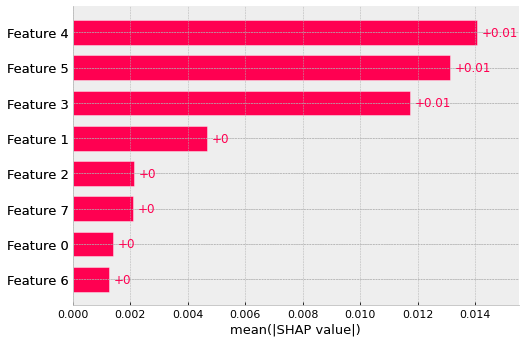

In [13]:
# compute SHAP values
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

In [14]:
well1 = df.groupby("well").get_group(1)
well2 = df.groupby("well").get_group(2)
well3 = df.groupby("well").get_group(3)
well4 = df.groupby("well").get_group(4)
well6 = df.groupby("well").get_group(6)
well7 = df.groupby("well").get_group(7)



NPHI1_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI2_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI3_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI4_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI5_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI6_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])


NPHI1_log["DEPT"], NPHI1_log["well_NPHI"], NPHI1_log["well_pridct"] = well1["DEPT"], well1["NPHI"], model.predict(scaler.transform(well1.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI2_log["DEPT"], NPHI2_log["well_NPHI"], NPHI2_log["well_pridct"] = well2["DEPT"], well2["NPHI"], model.predict(scaler.transform(well2.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI3_log["DEPT"], NPHI3_log["well_NPHI"], NPHI3_log["well_pridct"] = well3["DEPT"], well3["NPHI"], model.predict(scaler.transform(well3.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI4_log["DEPT"], NPHI4_log["well_NPHI"], NPHI4_log["well_pridct"] = well4["DEPT"], well4["NPHI"], model.predict(scaler.transform(well4.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI5_log["DEPT"], NPHI5_log["well_NPHI"], NPHI5_log["well_pridct"] = well6["DEPT"], well6["NPHI"], model.predict(scaler.transform(well6.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI6_log["DEPT"], NPHI6_log["well_NPHI"], NPHI6_log["well_pridct"] = well7["DEPT"], well7["NPHI"], model.predict(scaler.transform(well7.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))





NPHIs_log = [NPHI1_log,
             NPHI2_log,
             NPHI3_log,
             NPHI4_log,
             NPHI5_log,
             NPHI6_log]

59/59 [==============================] - 0s 1ms/step


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose l

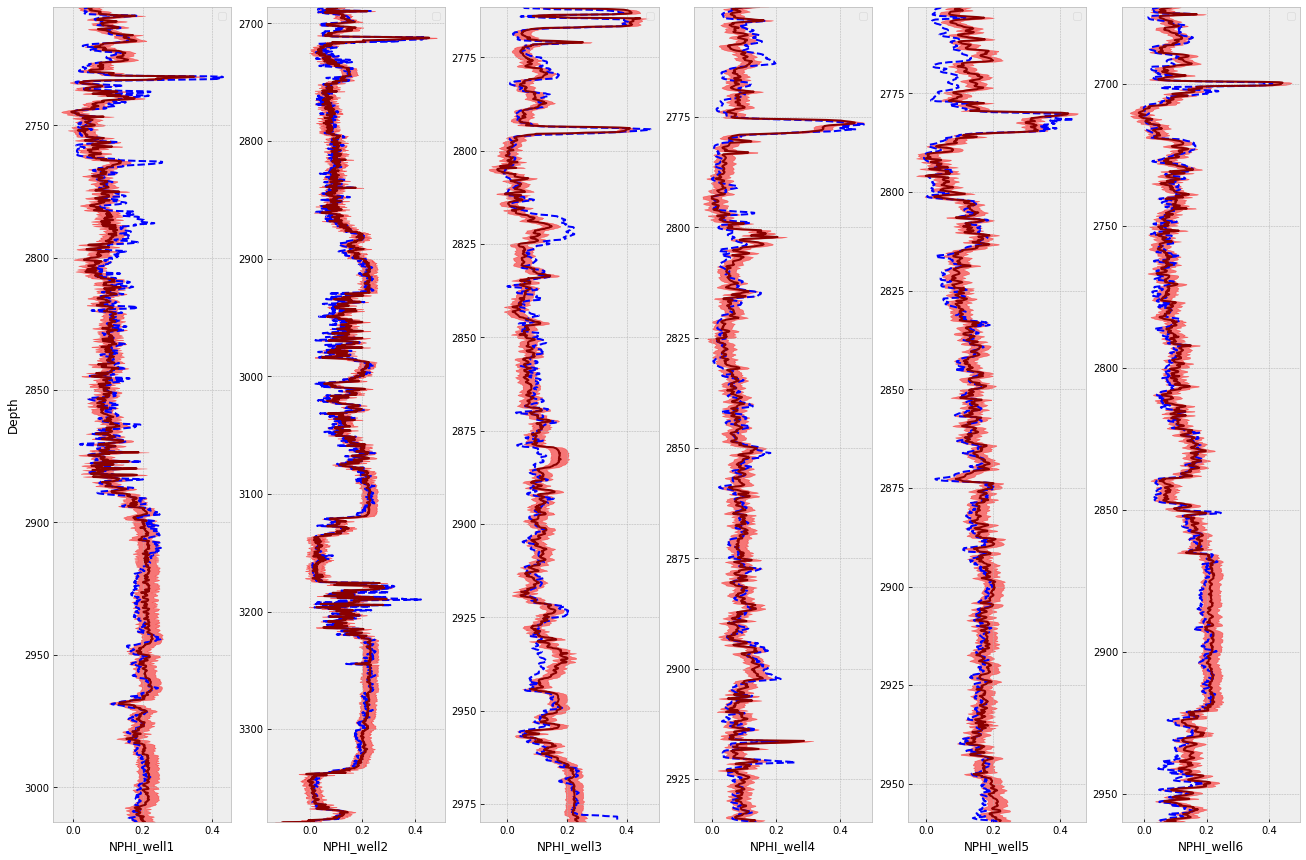

In [15]:
fig, axes = plt.subplots(figsize=(30,15), sharey=True)

for i, logs in enumerate(NPHIs_log):
    globals()['axes{}'.format(i)] = plt.subplot2grid((1,8), (0,i), rowspan=1, colspan = 1) 
    globals()['axes{}'.format(i)].plot(logs["well_NPHI"].values, logs["DEPT"].values, color="b", alpha=1, linestyle='dashed')
    globals()['axes{}'.format(i)].plot(logs["well_pridct"].values, logs["DEPT"].values, color="darkred")
    globals()['axes{}'.format(i)].fill_betweenx(logs["DEPT"].values, logs["well_pridct"].values-0.029, logs["well_pridct"].values+0.029, alpha=0.5, color='red')
    globals()['axes{}'.format(i)].set_xlabel(f"NPHI_well{i+1}")
    globals()['axes{}'.format(i)].legend()
    globals()['axes{}'.format(i)].set_ylim(logs["DEPT"].max(), logs["DEPT"].min())

axes0.set_ylabel('Depth')
plt.savefig("all_wells.png")
plt.show()

In [76]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(NPHI5_log["well_NPHI"].values, NPHI5_log["well_pridct"].values)

0.013643521103616489

In [77]:
model.save_weights("Best_model_well_6.h5")

In [105]:
train = df[~df['well'].isin(df.groupby("well").get_group(2)['well'])]
test = df.groupby("well").get_group(2)


X_train = train.drop(["NPHI", "RHOB","DRHO", "well"], axis=1).values
y_train = train["NPHI"].values

X_test = test.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1).values
y_test = test["NPHI"].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

Epoch 1/1000
259/259 [==============================] - 4s 8ms/step - loss: 0.6206 - root_mean_squared_error: 0.7878 - val_loss: 0.0298 - val_root_mean_squared_error: 0.1726
Epoch 2/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.1842 - root_mean_squared_error: 0.4291 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0801
Epoch 3/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0834 - root_mean_squared_error: 0.2889 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 4/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0370 - root_mean_squared_error: 0.1924 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 5/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0151 - root_mean_squared_error: 0.1227 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 6/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0061 - root_mean_squared_error: 0.0781 - val_loss: 0

Epoch 93/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0013 - root_mean_squared_error: 0.0354 - val_loss: 7.4127e-04 - val_root_mean_squared_error: 0.0272
Epoch 94/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0012 - root_mean_squared_error: 0.0352 - val_loss: 8.1250e-04 - val_root_mean_squared_error: 0.0285
Epoch 95/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 8.5690e-04 - val_root_mean_squared_error: 0.0293
Epoch 96/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 97/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 7.4475e-04 - val_root_mean_squared_error: 0.0273
Epoch 98/1000
259/259 [==============================] - 1s 6ms/step - loss: 0.0012 - root_mean_squared_error

259/259 [==============================] - 1s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 8.6051e-04 - val_root_mean_squared_error: 0.0293
Epoch 184/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 8.0772e-04 - val_root_mean_squared_error: 0.0284
Epoch 185/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 8.2611e-04 - val_root_mean_squared_error: 0.0287
Epoch 186/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 7.8680e-04 - val_root_mean_squared_error: 0.0281
Epoch 187/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0332 - val_loss: 8.0321e-04 - val_root_mean_squared_error: 0.0283
Epoch 188/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0

259/259 [==============================] - 1s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323 - val_loss: 7.9763e-04 - val_root_mean_squared_error: 0.0282
Epoch 274/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323 - val_loss: 7.7733e-04 - val_root_mean_squared_error: 0.0279
Epoch 275/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 7.6346e-04 - val_root_mean_squared_error: 0.0276
Epoch 276/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323 - val_loss: 8.2205e-04 - val_root_mean_squared_error: 0.0287
Epoch 277/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0323 - val_loss: 8.0736e-04 - val_root_mean_squared_error: 0.0284
Epoch 278/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0

259/259 [==============================] - 1s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 9.1209e-04 - val_root_mean_squared_error: 0.0302
Epoch 364/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 8.5861e-04 - val_root_mean_squared_error: 0.0293
Epoch 365/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 8.4967e-04 - val_root_mean_squared_error: 0.0291
Epoch 366/1000
259/259 [==============================] - 1s 5ms/step - loss: 9.9196e-04 - root_mean_squared_error: 0.0315 - val_loss: 7.9813e-04 - val_root_mean_squared_error: 0.0283
Epoch 367/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0318 - val_loss: 8.2488e-04 - val_root_mean_squared_error: 0.0287
Epoch 368/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0010 - root_mean_squared_error:

Epoch 453/1000
259/259 [==============================] - 1s 5ms/step - loss: 9.8267e-04 - root_mean_squared_error: 0.0313 - val_loss: 8.4262e-04 - val_root_mean_squared_error: 0.0290
Epoch 454/1000
259/259 [==============================] - 1s 5ms/step - loss: 9.7974e-04 - root_mean_squared_error: 0.0313 - val_loss: 8.0776e-04 - val_root_mean_squared_error: 0.0284
Epoch 455/1000
259/259 [==============================] - 1s 5ms/step - loss: 9.7905e-04 - root_mean_squared_error: 0.0313 - val_loss: 7.9449e-04 - val_root_mean_squared_error: 0.0282
Epoch 456/1000
259/259 [==============================] - 1s 5ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 9.3010e-04 - val_root_mean_squared_error: 0.0305
Epoch 457/1000
259/259 [==============================] - 1s 5ms/step - loss: 9.9739e-04 - root_mean_squared_error: 0.0316 - val_loss: 8.9411e-04 - val_root_mean_squared_error: 0.0299
Epoch 458/1000
259/259 [==============================] - 1s 5ms/step - loss: 9.8418

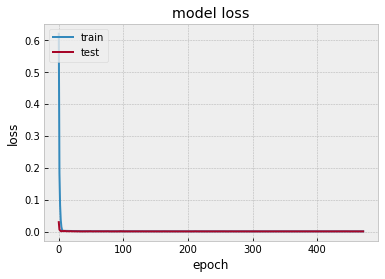

143/143 [==============================] - 0s 1ms/step
0.8603229005088224


In [106]:
model = model_creator()
    
    
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,profile_batch=(100, 200))
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f"model_best.h5", save_weights_only=True,best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)

history = model.fit(X_train, y_train,
                batch_size=50,
                callbacks=[early_stopping_cb,checkpoint_cb,tensorboard_cb],
                validation_data=(X_test, y_test),
                epochs=1000,
                verbose=1)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print(r2_score(y_test, model.predict(X_test)))

In [107]:
model.load_weights("model_best.h5")
print(r2_score(y_test, model.predict(X_test)))

143/143 [==============================] - 0s 2ms/step
0.8603229005088224


143/143 [==============================] - 0s 1ms/step


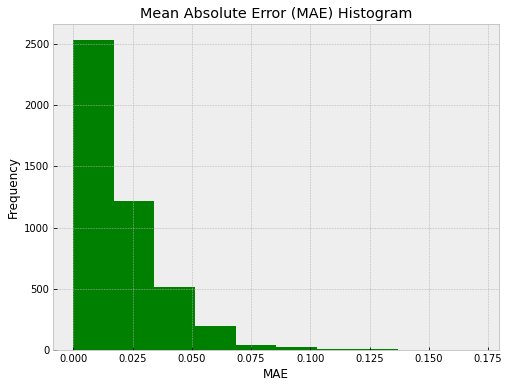

In [110]:
# Calculate the Mean Absolute Error (MAE)
y_pred = model.predict(X_test)
mae = np.abs(y_test - np.reshape(y_pred,y_pred.shape[0]))

# Plot the MAE histogram
plt.figure(figsize=(8, 6))
plt.hist(mae, color="green")
# , bins=3, edgecolor='red'
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.title('Mean Absolute Error (MAE) Histogram')
plt.show()

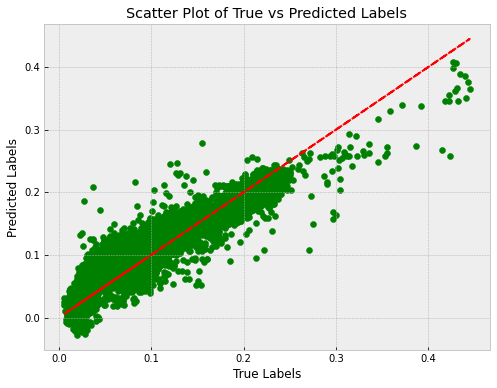

In [111]:
y_pred = np.reshape(y_pred,y_pred.shape[0])
# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color="green")
plt.plot(y_test,y_test, linestyle = 'dashed', color="red")
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Scatter Plot of True vs Predicted Labels')
plt.show()

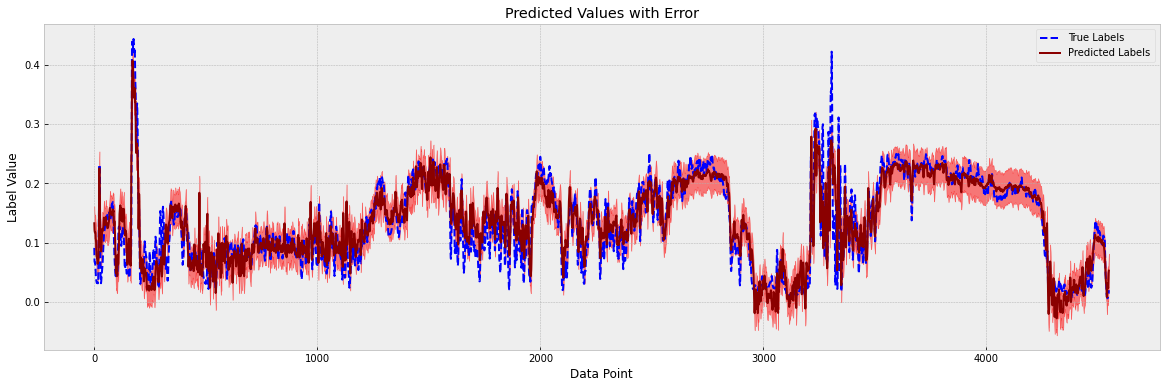

In [112]:
y_true = y_test
# Calculate the error between true and predicted labels
error = y_true - y_pred

# Plot the predicted values and error
plt.figure(figsize=(20, 6))
plt.plot(y_true, label='True Labels', color="b", alpha=1, linestyle = 'dashed')
plt.plot(y_pred, label='Predicted Labels', color="darkred")
plt.fill_between(range(len(y_true)), y_pred-0.029, y_pred+0.029, alpha=0.5, color='red')

plt.xlabel('Data Point')
plt.ylabel('Label Value')
plt.title('Predicted Values with Error')
plt.legend()
plt.show()

In [113]:
well1 = df.groupby("well").get_group(1)
well2 = df.groupby("well").get_group(2)
# well3 = df.groupby("well").get_group(3)
well4 = df.groupby("well").get_group(4)
well6 = df.groupby("well").get_group(6)
well7 = df.groupby("well").get_group(7)



NPHI1_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI2_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI3_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI4_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI5_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI6_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])


NPHI1_log["DEPT"], NPHI1_log["well_NPHI"], NPHI1_log["well_pridct"] = well1["DEPT"], well1["NPHI"], model.predict(scaler.transform(well1.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI2_log["DEPT"], NPHI2_log["well_NPHI"], NPHI2_log["well_pridct"] = well2["DEPT"], well2["NPHI"], model.predict(scaler.transform(well2.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI3_log["DEPT"], NPHI3_log["well_NPHI"], NPHI3_log["well_pridct"] = well3["DEPT"], well3["NPHI"], model.predict(scaler.transform(well3.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI4_log["DEPT"], NPHI4_log["well_NPHI"], NPHI4_log["well_pridct"] = well4["DEPT"], well4["NPHI"], model.predict(scaler.transform(well4.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI5_log["DEPT"], NPHI5_log["well_NPHI"], NPHI5_log["well_pridct"] = well6["DEPT"], well6["NPHI"], model.predict(scaler.transform(well6.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI6_log["DEPT"], NPHI6_log["well_NPHI"], NPHI6_log["well_pridct"] = well7["DEPT"], well7["NPHI"], model.predict(scaler.transform(well7.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))





NPHIs_log = [NPHI1_log,
             NPHI2_log,
             NPHI3_log,
             NPHI4_log,
             NPHI5_log,
             NPHI6_log]

64/64 [==============================] - 0s 1ms/step


X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names


45/45 [==============================] - 0s 2ms/step


X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names


43/43 [==============================] - 0s 2ms/step


X has feature names, but StandardScaler was fitted without feature names
X has feature names, but StandardScaler was fitted without feature names


59/59 [==============================] - 0s 2ms/step


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose l

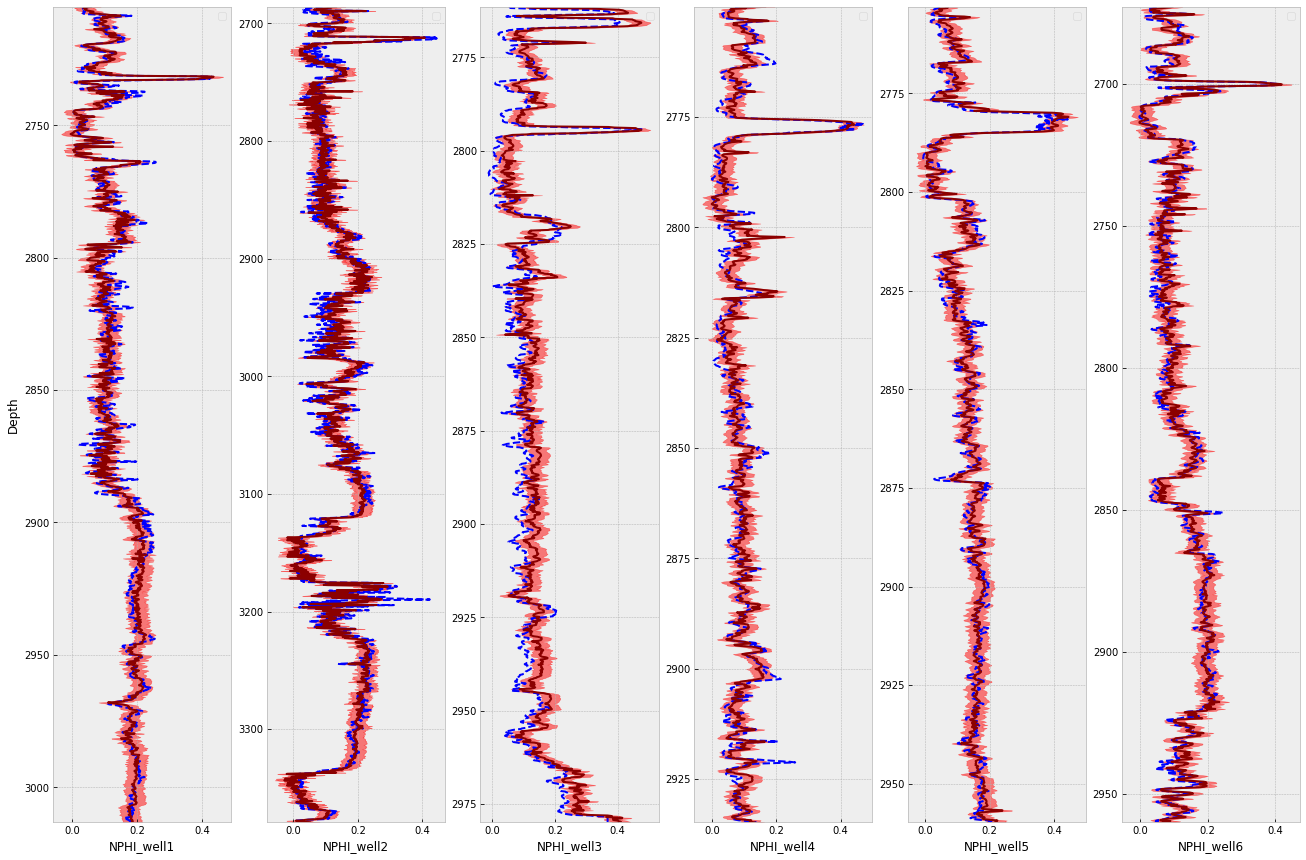

In [114]:
fig, axes = plt.subplots(figsize=(30,15), sharey=True)

for i, logs in enumerate(NPHIs_log):
    globals()['axes{}'.format(i)] = plt.subplot2grid((1,8), (0,i), rowspan=1, colspan = 1) 
    globals()['axes{}'.format(i)].plot(logs["well_NPHI"].values, logs["DEPT"].values, color="b", alpha=1, linestyle='dashed')
    globals()['axes{}'.format(i)].plot(logs["well_pridct"].values, logs["DEPT"].values, color="darkred")
    globals()['axes{}'.format(i)].fill_betweenx(logs["DEPT"].values, logs["well_pridct"].values-0.029, logs["well_pridct"].values+0.029, alpha=0.5, color='red')
    globals()['axes{}'.format(i)].set_xlabel(f"NPHI_well{i+1}")
    globals()['axes{}'.format(i)].legend()
    globals()['axes{}'.format(i)].set_ylim(logs["DEPT"].max(), logs["DEPT"].min())

axes0.set_ylabel('Depth')

plt.show()